# Install & Imports

In [ ]:
%%capture
!pip install sentencepiece
!pip install transformers[sentencepiece] datasets

In [ ]:
import math
import random
import numpy as np
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')

In [ ]:
# plot style configuration
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
rcParams['figure.figsize'] = 12, 8

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 1) Data loading & preprocessing

Dans cette partie, nous allons charger un dataset contenant des paires de phrases en Anglais et Français. Nous ne chargerons que quelques phrases dans un premier temps mais vous êtes invités à en charger plus si vous souhaitez de meilleurs performances de la part de vos modèles. Pour cela, nous allons utiliser la librairie [datasets](https://huggingface.co/docs/datasets/index) et charger le jeu de données depuis le [hub hugging face](https://huggingface.co/datasets).

Ensuite, nous utiliserons la librairie [transformer](https://huggingface.co/docs/transformers/index) pour charger un tokenizer déjà entraîné (celui du modèle [T5](https://huggingface.co/google-t5/t5-base)). Le dataset sera tokenizé puis découpé en séquences de 64 tokens avant d'être transformé en DataLoader PyTorch.



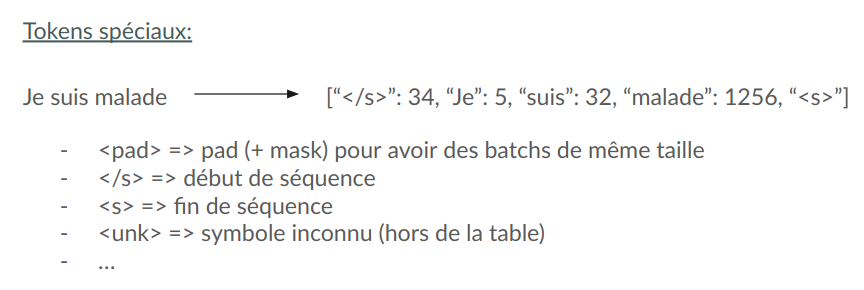

In [ ]:
from datasets import load_dataset
# Load the opus_books translation dataset (en-fr split)
raw_datasets = load_dataset("opus_books", "en-fr")
# Only keep the first 110 entries (too slow for our exercise otherwise)
raw_datasets["train"] = raw_datasets["train"].select(range(110))
# Random train/test split (10% goes to the test set)
split_datasets = raw_datasets["train"].train_test_split(train_size=0.9, seed=20)

# Load T5's tokenizer
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("t5-base",
                                          bos_token='<s>',
                                          add_bos_token=True,
                                          return_tensors="pt")

# Create the datasets:
#  - sequences of 64 tokens
#  - truncate if too long
#  - pad if too short
#  - add bos token at the beginning of each target sequence

max_length = 64
def preprocess_function(examples):
    inputs = [ex["en"] for ex in examples["translation"]]
    targets = [ex["fr"] for ex in examples["translation"]]
    model_inputs = tokenizer(
        inputs, text_target=targets, max_length=max_length, truncation=True, padding='max_length'
    )
    model_inputs["labels"] = [[tokenizer.bos_token_id] + _labels[:-1] for _labels in model_inputs["labels"]]
    return model_inputs

tokenized_datasets = split_datasets.map(
    preprocess_function,
    batched=True,
    remove_columns=split_datasets["train"].column_names,
)

In [ ]:
# Create Pytorch DataLoaders
# Use batch_size = 1 to ease the implementation
tokenized_datasets.set_format("torch")
train_dataloader = DataLoader(
    tokenized_datasets["train"],
    shuffle=True,
    batch_size=1,
)
test_dataloader = DataLoader(
    tokenized_datasets["test"], batch_size=1
)

Jetons maintenant un coup d'oeil au dataset de training:

In [ ]:
# Quick overview of the dataset
for _batch_idx, batch in enumerate(train_dataloader):
  print(f"Entry {_batch_idx}")
  print(tokenizer.decode(batch["input_ids"][0]))
  print(tokenizer.decode(batch["labels"][0]))
  if _batch_idx > 4:
    break

# 2) Seq2Seq RNN

*Note: le code suivant est inspiré de [l'exemple de Seq2Seq de PyTorch](https://github.com/bentrevett/pytorch-seq2seq/blob/main/1%20-%20Sequence%20to%20Sequence%20Learning%20with%20Neural%20Networks.ipynb).*

Commençons par implémenter un RNN multi-couches. Notez que la fonction d'activation à utiliser ici est TanH.

Remplacez `<your code>` dans ma méthode forward par la bonne utilisation des poids définis dans `__init__` pour calculer le hidden state de chaque couche. A noter que nous n'utiliserons pas de batch dans ce notebook pour simplifier l'implémentation (i.e. chaque opération sera faite sur un seul exemple).

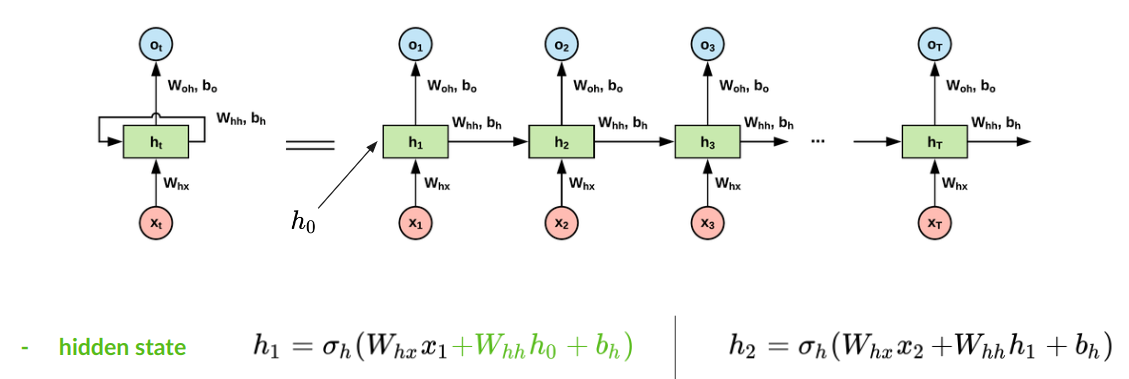

In [ ]:
class RNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_layers):
        super().__init__()
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim

        ##### RNN WEIGHTS #####
        w_hx = []
        w_hh = []
        for layer in range(n_layers):
            if layer == 0:
                w_hx.append(nn.Linear(input_dim, hidden_dim, bias=False))
            else:
                w_hx.append(nn.Linear(hidden_dim, hidden_dim, bias=False))

            w_hh.append(nn.Linear(hidden_dim, hidden_dim, bias=True))

        self.weights = torch.nn.ModuleDict({
            "hx": torch.nn.ModuleList(w_hx),
            "hh": torch.nn.ModuleList(w_hh),
        })

    def forward(self, x, h_0=None):
        seq_len = x.shape[0]
        if h_0 is None:
            h_0 = torch.zeros(self.n_layers, self.hidden_dim).to(device)
        h_t_minus_1 = h_0
        h_t = h_0
        last_layer_hidden_states = []
        for t in range(seq_len):
            for layer in range(self.n_layers):
                if layer == 0:
                    h_t[layer] = <your code>
                else:
                  h_t[layer] = <your code>

            last_layer_hidden_states.append(h_t[-1])
            h_t_minus_1 = h_t
        last_layer_hidden_states = torch.stack(last_layer_hidden_states)
        return last_layer_hidden_states, h_t

Utilisons maintenant ce RNN pour créer un modèle Seq2Seq:

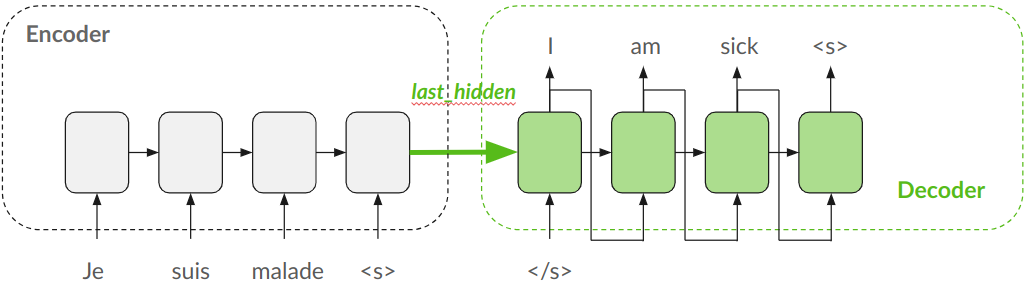

In [ ]:
class RNNEncoder(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, n_layers):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.rnn = RNN(embedding_dim, hidden_dim, n_layers)

    def forward(self, src):
        embedded = self.embedding(src)
        last_layer_hidden_states, last_hidden = self.rnn(embedded)
        return last_hidden

In [ ]:
class RNNDecoder(nn.Module):
    def __init__(self, output_dim, embedding_dim, hidden_dim, n_layers):
        super().__init__()
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.embedding = nn.Embedding(output_dim, embedding_dim)
        self.rnn = RNN(embedding_dim, hidden_dim, n_layers)
        self.w_oh = nn.Linear(hidden_dim, output_dim, bias=True)

    def forward(self, input, last_hidden):
        input = input.unsqueeze(0)
        embedded = self.embedding(input)
        last_layer_hidden_states, _last_hidden = self.rnn(embedded, last_hidden)
        output = self.w_oh(last_layer_hidden_states[-1].squeeze(0))
        return output, _last_hidden

Implémentez maintenant:
- la méthode `forward` pour obtenir les predictions pour chaque token de la phrase target `trg`
- la méthode `generate`, faisant la même chose que `forward`, mais utilisant les tokens prédis comme entrée du decoder

In [ ]:
class RNNSeq2Seq(nn.Module):
    def __init__(self, vocab_dim, embedding_dim, hidden_dim, n_layers, device):
        super().__init__()
        self.encoder = RNNEncoder(
            vocab_dim,
            embedding_dim,
            hidden_dim,
            n_layers
        )
        self.decoder = RNNDecoder(
            vocab_dim,
            embedding_dim,
            hidden_dim,
            n_layers
        )
        self.device = device
        self.init_weights()

    def init_weights(self):
      for name, param in self.named_parameters():
          nn.init.uniform_(param.data, -0.08, 0.08)

    def forward(self, src, trg):
        '''
        Forward function to compute all the hidden states given a source and target sequence for the encoder and decoder respectively.
        '''
        trg_length = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        # tensor to store decoder outputs
        outputs = torch.zeros(trg_length, trg_vocab_size).to(self.device)
        # last hidden state of the encoder is used as the initial hidden state of the decoder
        last_hidden = <your code>
        # first input to the decoder is the <sos> tokens
        input = trg[0]
        for t in range(1, trg_length):
            # insert input token embedding and previous hidden tate in the decoder
            # receive output tensor (predictions) and new hidden state
            output, last_hidden = <your code>
            # compute log softmax over tokens and place predictions in the tensor holding predictions
            outputs[t] = F.log_softmax(output, dim=-1)
            # use the ground truth next token as next input
            input = <your code>
        return outputs

    def generate(self, src, max_len=10):
      '''
      Generate function to produce, given a source sequence passed to the encoder, an output sequence (created by the decoder)
      '''
      # last_hidden = <your code>
      last_hidden = self.encoder(src)
      output = [torch.Tensor([tokenizer.bos_token_id]).squeeze(0).to(torch.int32).to(device)]
      t = 1
      while output[-1] != tokenizer.eos_token_id and t < max_len:
        <your code>
        tokens_dist = F.log_softmax(decoder_output)
        token = tokens_dist.argmax()
        output.append(token)
        t += 1

      output = torch.stack(output)
      return output, None

Essayez maintenant d'entraîner votre modèle sur le dataset chargé en utilisant le code de la partie **Training**.

# 3) Attention-Augmented Seq2Seq RNN

Ajoutons maintenant l'additive attention entre l'encoder et le decoder:
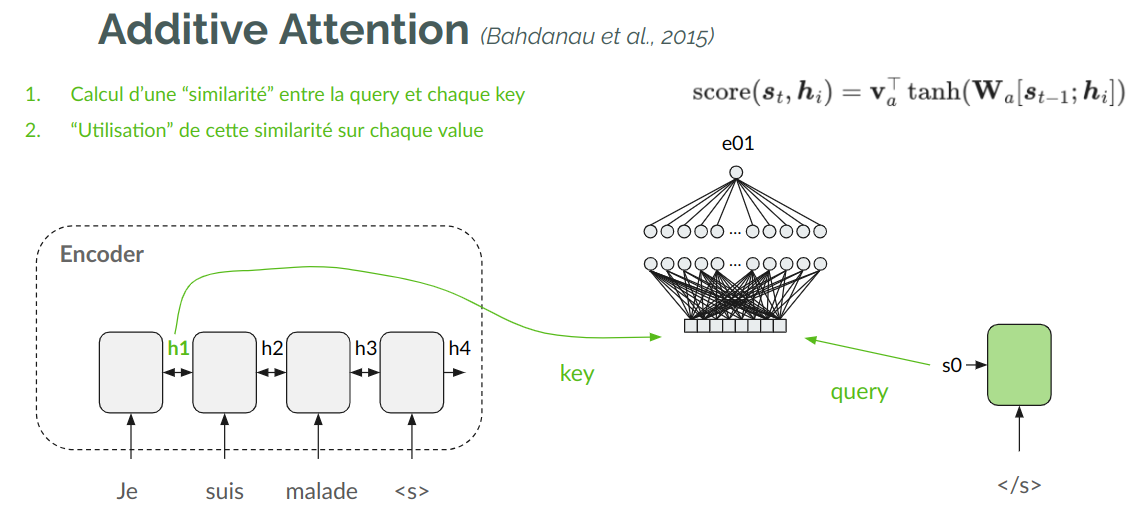

Nous allons l'ajouter dans le module de RNN utilisé par le decoder. Complétez la méthode `forward` du module ci-dessous tel que:
- `h_t_minus_1` soit concatené avec chaque h_i contenu par `encoder_last_layer_hidden_states`
- la "similarité" soit calculée sur chacune de ces concaténations avec `w_a` et `v_a` et mise dans la variable `scores`
- le context c_i soit calculé et mis dans `context`
- ce context soit utilisé dans le calcul de `h_t[layer]` en le passant à la couche linéaire `w_ch`

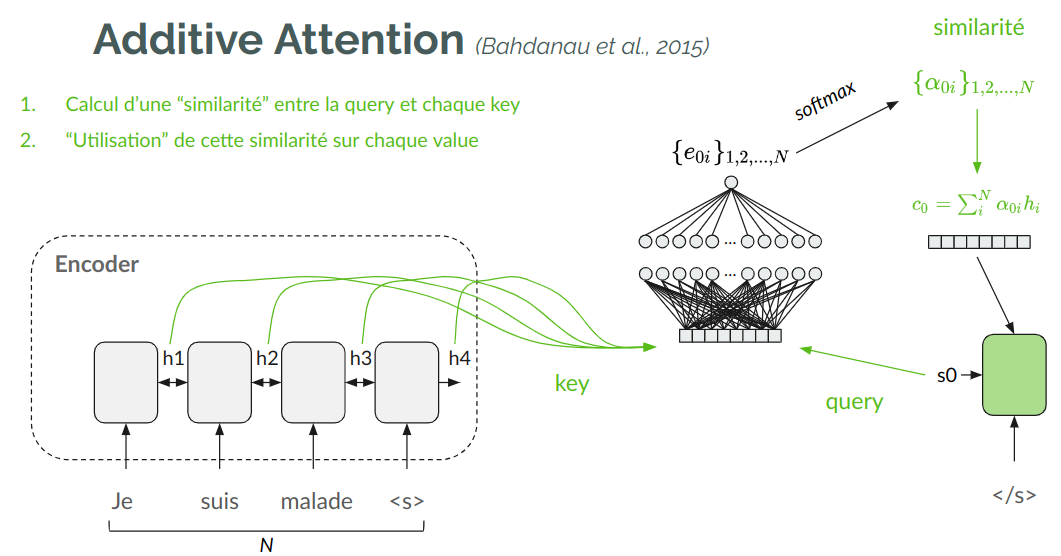

In [ ]:
class AttnAugmentedRNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_layers):
        super().__init__()
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim

        ##### RNN WEIGHTS #####
        w_hx = []
        w_hh = []
        w_ch = []
        for layer in range(n_layers):
            if layer == 0:
                w_hx.append(nn.Linear(input_dim, hidden_dim, bias=False))
            else:
                w_hx.append(nn.Linear(hidden_dim, hidden_dim, bias=False))

            w_hh.append(nn.Linear(hidden_dim, hidden_dim, bias=True))
            # weights to apply to the context produced by the additive attention
            w_ch.append(nn.Linear(hidden_dim, hidden_dim, bias=True))

        self.weights = torch.nn.ModuleDict({
            "hx": torch.nn.ModuleList(w_hx),
            "hh": torch.nn.ModuleList(w_hh),
            "ch": torch.nn.ModuleList(w_ch),
        })

        ##### ATTENTION WEIGHTS #####
        self.w_a = nn.Linear(2*hidden_dim, hidden_dim)
        self.v_a = nn.Linear(hidden_dim, 1)

    def forward(self, x, encoder_last_layer_hidden_states, h_0=None):
        seq_len = x.shape[0]
        if h_0 is None:
            h_0 = torch.zeros(self.n_layers, self.hidden_dim).to(device)
        h_t_minus_1 = h_0
        h_t = h_0
        last_layer_hidden_states = []
        for t in range(seq_len):
            for layer in range(self.n_layers):
                scores = <your code>
                attention_weights = F.softmax(scores)
                context = <your code>
                context = (attention_weights*encoder_last_layer_hidden_states).sum(axis=0)
                if layer == 0:
                    h_t[layer] = <your code>
                else:
                    h_t[layer] = <your code>

            last_layer_hidden_states.append(h_t[-1])
            h_t_minus_1 = h_t
        last_layer_hidden_states = torch.stack(last_layer_hidden_states)
        return last_layer_hidden_states, h_t

Nous allons maintenant ajouter ce nouveau AttnAugmentedRNN dans le decoder à la place de l'ancien RNN.

In [ ]:
class RNNAttnEncoder(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, n_layers):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.rnn = RNN(embedding_dim, hidden_dim, n_layers)

    def forward(self, src):
        embedded = self.embedding(src)
        last_layer_hidden_states, last_hidden = self.rnn(embedded)
        return last_layer_hidden_states, last_hidden

In [ ]:
class RNNAttnDecoder(nn.Module):
    def __init__(self, output_dim, embedding_dim, hidden_dim, n_layers):
        super().__init__()
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.embedding = nn.Embedding(output_dim, embedding_dim)
        self.rnn = AttnAugmentedRNN(embedding_dim, hidden_dim, n_layers)
        self.w_oh = nn.Linear(hidden_dim, output_dim)

    def forward(self, input, encoder_last_layer_hidden_states, encoder_last_hidden):
        input = input.unsqueeze(0)
        embedded = self.embedding(input)
        last_layer_hidden_states, last_hidden = self.rnn(embedded, encoder_last_layer_hidden_states, encoder_last_hidden)
        prediction = self.w_oh(last_layer_hidden_states[-1].squeeze(0))
        return prediction, last_hidden

Implémentez maintenant:
- la méthode `forward` pour obtenir les predictions pour chaque token de la phrase target `trg`
- la méthode `generate`, faisant la même chose que `forward`, mais utilisant les tokens prédis comme entrée du decoder

In [ ]:
class RNNAttnSeq2Seq(nn.Module):
    def __init__(self, vocab_dim, embedding_dim, hidden_dim, n_layers, device):
        super().__init__()
        self.encoder = RNNAttnEncoder(
            vocab_dim,
            embedding_dim,
            hidden_dim,
            n_layers
        )
        self.decoder = RNNAttnDecoder(
            vocab_dim,
            embedding_dim,
            hidden_dim,
            n_layers
        )
        self.device = device
        self.init_weights()

    def init_weights(self):
      for name, param in self.named_parameters():
          nn.init.uniform_(param.data, -0.08, 0.08)

    def forward(self, src, trg):
        trg_length = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        # tensor to store decoder outputs
        outputs = torch.zeros(trg_length, trg_vocab_size).to(self.device)
        # last hidden state of the encoder is used as the initial hidden state of the decoder
        # encoder's last layer hidden states are used in the additive attention
        encoder_last_layer_hidden_states, last_hidden = <your code>
        # first input to the decoder is the <sos> tokens
        input = trg[0]
        for t in range(1, trg_length):
            # insert input token embedding, previous hidden and previous cell states
            # receive output tensor (predictions) and new hidden and cell states
            output, last_hidden = <your code>
            # place predictions in a tensor holding predictions for each token
            outputs[t] = F.log_softmax(output, dim=-1)
            # use the ground truth next token as next input
            input = <your code>
        return outputs

    def generate(self, src, max_len=10):
      encoder_last_layer_hidden_states, last_hidden = self.encoder(src)
      # encoder_last_layer_hidden_states, last_hidden = <your code>
      input = torch.tensor(tokenizer.bos_token_id).to(device)
      output = torch.zeros(max_len).to(self.device)
      output[0] = tokenizer.bos_token_id
      t = 1
      while input != tokenizer.eos_token_id and t < max_len:
        <your code>
        tokens_dist = F.log_softmax(decoder_output)
        token = tokens_dist.argmax()
        output[t] = token
        input = token
        t += 1

      output[t+1:] = tokenizer.pad_token_id
      return output, None

Essayez maintenant d'entraîner votre modèle sur le dataset chargé en utilisant le code de la partie **Training**.

# 4) Self-Attention



Implémentez la Scaled Dot-Product Attention que nous utiliserons ensuite dans un module de Self-Attention.

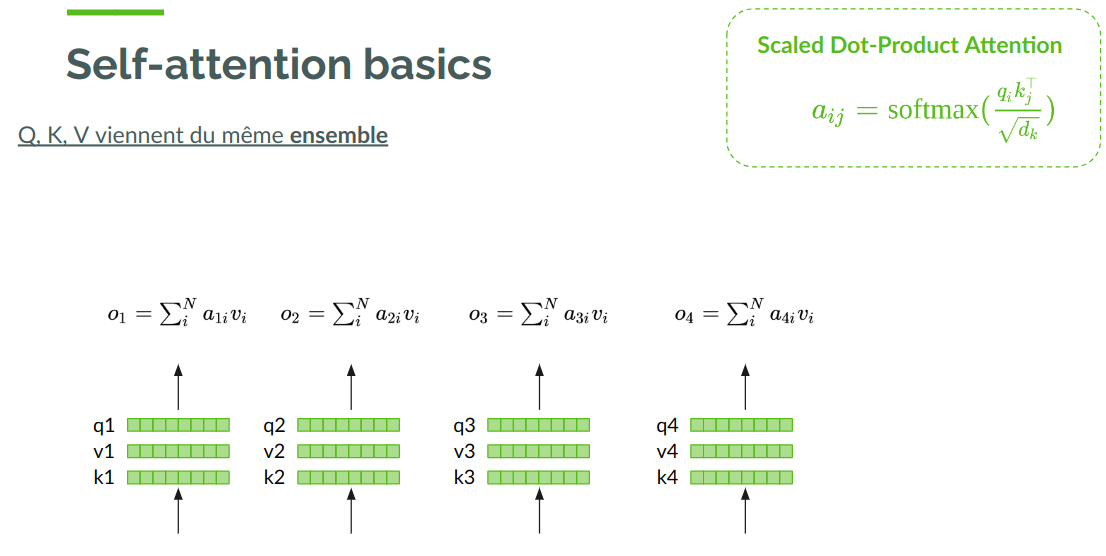

In [ ]:
class ScaledDotProductAttention(nn.Module):
    """ Computes scaled dot product attention
    """

    def __init__(self, scale):
        super(ScaledDotProductAttention, self).__init__()
        self.scale = scale


    def forward(self, query, key, value, mask=None):
        """ query: (query_len, head_dim)
            key: (key_len, head_dim)
            value: (value_len, head_dim)
            mask: (1, 1, source_seq_len) for source mask
                  (1, target_seq_len, target_seq_len) for target mask
        """
        # calculate similarity scores
        scores = <your code>  # (query_len, value_len)

        # mask out invalid positions
        if mask is not None:
            scores = scores.masked_fill(mask == 0, float('-inf'))  # (query_len, value_len)

        # calculate the attention weights (prob) from similarity scores
        attn_probs = F.softmax(scores, dim=1) # (query_len, value_len)

        # calculate context vector
        output = <your code>  # (query_len, head_dim)

        # output: (query_len, head_dim)
        # attn_probs: (query_len, value_len)
        return output, attn_probs

Ajoutons maintenant cette opération dans une head de Self-Attention.

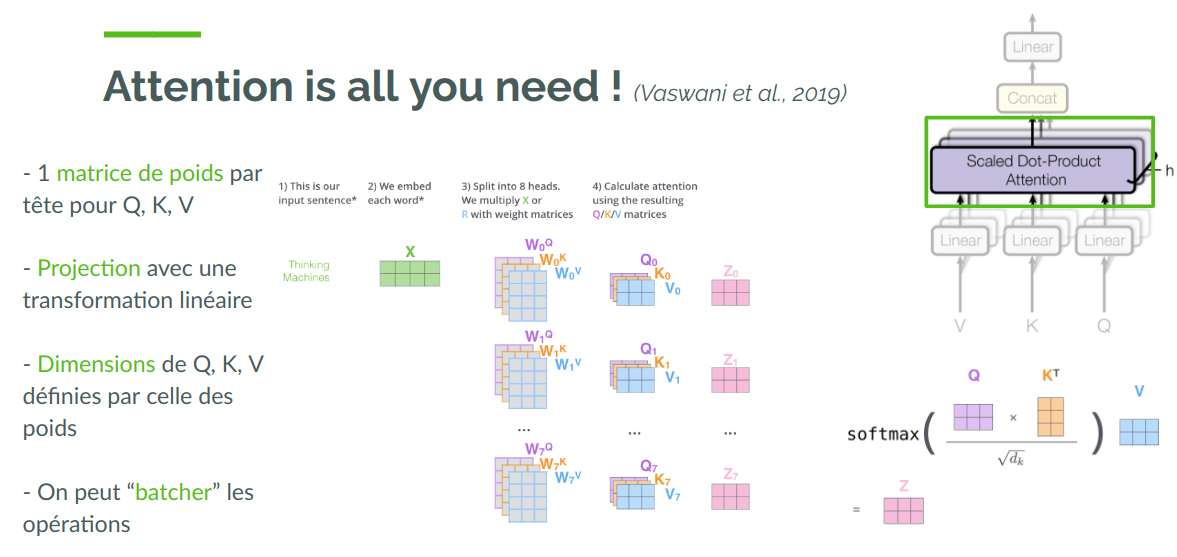

In [ ]:
class SingleHeadAttention(nn.Module):
    def __init__(self, d_model):
        super(SingleHeadAttention, self).__init__()

        self.d_model = d_model
        self.d_k = self.d_v = d_model
        self.W_q = nn.Linear(d_model, d_model, bias=False)
        self.W_k = nn.Linear(d_model, d_model, bias=False)
        self.W_v = nn.Linear(d_model, d_model, bias=False)
        self.W_o = nn.Linear(d_model, d_model)

        self.attention = ScaledDotProductAttention(np.sqrt(self.d_k))


    def forward(self, query, key, value, mask=None):
        """ query: (query_len, d_model)
            key: (key_len, d_model)
            value: (value_len, d_model)
            mask: (1, source_seq_len) for source mask
                  (target_seq_len, target_seq_len) for target mask
        """
        # apply linear projctions to query, key and value
        Q = self.W_q(query)  # (query_len, head_dim)
        K = self.W_k(key)  # (key_len, head_dim)
        V = self.W_v(value)  # (value_len, head_dim)

        # calculate attention weights and context vector for each of the heads
        x, attn = self.attention(Q, K, V, mask)

        # x: (query_len, head_dim)
        # attn: (query_len, value_len)

        # apply linear projection to concatenated context vector
        x = self.W_o(x)  # (query_len, d_model)

        # x: (query_len, d_model)
        # attn: (query_len, value_len)
        return x, attn

# 5) Transformer

On termine ce TP par l'implémentation complète du Transformer !

Commençons par le layer utilisé dans l'encoder.

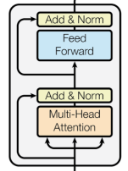

Utilisez la head de Self-Attention défini plus haut. Pour des raisons de ressources limitées, nous utiliserons une seule head dans l'encoder et le decoder.



In [ ]:
class EncoderLayer(nn.Module):

    def __init__(self, d_model, d_ff):
        super(EncoderLayer, self).__init__()
        self.d_model = d_model
        self.d_ff = d_ff

        self.attn_layer = SingleHeadAttention(d_model)
        self.attn_layer_norm = nn.LayerNorm(d_model, eps=1e-6)

        self.ff_w_1 = nn.Linear(d_model, d_ff)
        self.ff_w_2 = nn.Linear(d_ff, d_model)
        self.ff_layer_norm = nn.LayerNorm(d_model, eps=1e-6)


    def forward(self, x, mask):
        """ x: (source_seq_len, d_model)
            mask: (1, source_seq_len)
        """
        # apply self-attention
        attn_output, _ = self.attn_layer(<your code>, <your code>, <your code>, mask)  # (source_seq_len, d_model)

        # apply residual connection followed by layer normalization
        attn_output = self.attn_layer_norm(<your code>)  # (source_seq_len, d_model)

        # apply position-wise feed-forward
        ff_output = F.relu(self.ff_w_1(attn_output))  # (seq_len, d_ff)
        ff_output = self.ff_w_2(ff_output)  # (seq_len, d_model)

        # apply residual connection followed by layer normalization
        block_output = self.ff_layer_norm(attn_output + ff_output)  # (source_seq_len, d_model)

        # x: (source_seq_len, d_model)
        return block_output

Faisons de même pour le layer du decoder (attention il y a en plus une attention sur les sorties de l'encoder).

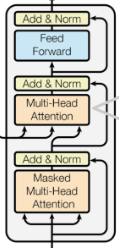

In [ ]:
class DecoderLayer(nn.Module):

    def __init__(self, d_model, d_ff):
        super(DecoderLayer, self).__init__()
        self.d_model = d_model
        self.d_ff = d_ff

        self.attn_layer = SingleHeadAttention(d_model)
        self.attn_layer_norm = nn.LayerNorm(d_model, eps=1e-6)

        self.enc_attn_layer = SingleHeadAttention(d_model)
        self.enc_attn_layer_norm = nn.LayerNorm(d_model, eps=1e-6)

        self.ff_w_1 = nn.Linear(d_model, d_ff)
        self.ff_w_2 = nn.Linear(d_ff, d_model)
        self.ff_layer_norm = nn.LayerNorm(d_model, eps=1e-6)


    def forward(self, x, memory, src_mask, tgt_mask):
        """ x: (target_seq_len, d_model)
            memory: (source_seq_len, d_model)
            src_mask: (1, source_seq_len)
            tgt_mask: (target_seq_len, target_seq_len)
        """
        # apply self-attention
        self_attn_output, _ = self.attn_layer(<your code>, <your code>, <your code>, tgt_mask)  # (source_seq_len, d_model)

        # apply residual connection followed by layer normalization
        self_attn_output = self.attn_layer_norm(<your code>)  # (source_seq_len, d_model)

        # apply encoder-decoder attention
        # memory is the output from encoder block (encoder states)
        attn_output, attn = self.enc_attn_layer(<your code>, <your code>, <your code>, src_mask)

        # attn_output: (target_seq_len, d_model)
        # attn: (n_heads, target_seq_len, source_seq_len)

        # apply residual connection followed by layer normalization
        attn_output = self.enc_attn_layer_norm(<your code>)  # (target_seq_len, d_model)

        # apply position-wise feed-forward
        ff_output = F.relu(self.ff_w_1(attn_output))  # (seq_len, d_ff)
        ff_output = self.ff_w_2(ff_output)  # (seq_len, d_model)

        # apply residual connection followed by layer normalization
        block_output = self.ff_layer_norm(attn_output + ff_output)  # (source_seq_len, d_model)

        # x: (source_seq_len, d_model)
        return block_output, attn

Nous préparons ensuite un Sinusoidal Positional Encoding.

In [ ]:
class PositionalEncoding(nn.Module):
    """ Implements the sinusoidal positional encoding.
    """

    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.d_model = d_model
        self.max_len = max_len

        # compute positional encodings
        pe = torch.zeros(max_len, d_model)  # (max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)  # (max_len, 1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)
        )  # (d_model,)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        # pe = pe.unsqueeze(0).transpose(0, 1)  # (max_len, 1, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """ x: (seq_len, d_model)
        """

        x = x + self.pe[:x.size(0), :]  # (seq_len, d_model)

        # x: (seq_len, d_model)
        return x

Puis il est temps de créer l'encoder en entier !

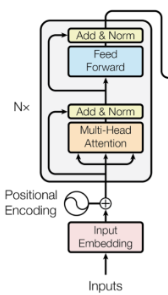

In [ ]:
class Encoder(nn.Module):
    """ Encoder block is a stack of N identical encoder layers.
    """

    def __init__(self, vocab_size, d_model, n_layers, d_ff, pad_idx, max_len=5000):
        super(Encoder, self).__init__()
        self.vocab_size = vocab_size
        self.d_model = d_model
        self.n_layers = n_layers
        self.d_ff = d_ff
        self.pad_idx = pad_idx
        self.max_len = max_len

        self.tok_embedding = nn.Embedding(vocab_size, d_model, padding_idx=pad_idx)
        self.pos_embedding = PositionalEncoding(d_model, max_len)
        self.layers = nn.ModuleList([
            EncoderLayer(d_model, d_ff)
            for _ in range(n_layers)
        ])
        self.layer_norm = nn.LayerNorm(d_model, eps=1e-6)


    def forward(self, x, mask):
        """ x: (source_seq_len)
            mask: (1, source_seq_len)
        """
        # apply positional encoding to token sequences
        x = self.tok_embedding(x)  # (source_seq_len, d_model)
        x = self.pos_embedding(x)  # (source_seq_len, d_model)

        for layer in self.layers:
            x = layer(x, mask)  # (source_seq_len, d_model)

        x = self.layer_norm(x)  # (source_seq_len, d_model)

        # x: (source_seq_len, d_model)
        return x

Au tour du Decoder :)

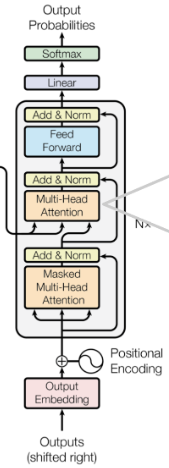

In [ ]:
class Decoder(nn.Module):
    """ Decoder block is a stack of N identical decoder layers.
    """

    def __init__(self, vocab_size, d_model, n_layers, d_ff, pad_idx, max_len=5000):
        super(Decoder, self).__init__()
        self.vocab_size = vocab_size
        self.d_model = d_model
        self.n_layers = n_layers
        self.d_ff = d_ff
        self.pad_idx = pad_idx
        self.max_len = max_len

        self.tok_embedding = nn.Embedding(vocab_size, d_model, padding_idx=pad_idx)
        self.pos_embedding = PositionalEncoding(d_model, max_len)
        self.layers = nn.ModuleList([
            DecoderLayer(d_model, d_ff)
            for _ in range(n_layers)
        ])
        self.layer_norm = nn.LayerNorm(d_model, eps=1e-6)


    def forward(self, x, memory, src_mask, tgt_mask):
        """ x: (target_seq_len, d_model)
            memory: (source_seq_len, d_model)
            src_mask: (1, source_seq_len)
            tgt_mask: (target_seq_len, target_seq_len)
        """
        # apply positional encoding to token sequences
        x = self.tok_embedding(x)  # (target_seq_len, d_model)
        x = self.pos_embedding(x)  # (target_seq_len, d_model)

        for layer in self.layers:
            x, attn = layer(x, memory, src_mask, tgt_mask)  # (target_seq_len, d_model)

        x = self.layer_norm(x)  # (target_seq_len, d_model)

        # x: (target_seq_len, d_model)
        # attn: (n_heads, target_seq_len, source_seq_len)
        return x, attn

Vous touchez au but ! Finissez d'implémenter la méthode `forward` et `generate` de l'architecture complète.

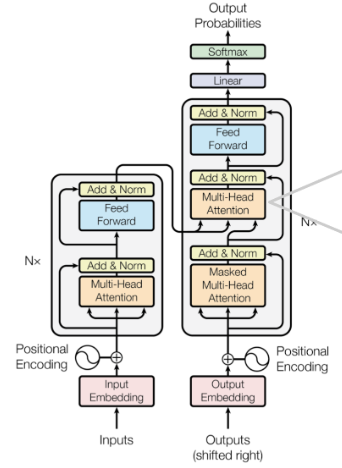

In [ ]:
class Transformer(nn.Module):
    """ Transformer wrapper for encoder and decoder.
    """

    def __init__(self, vocab_dim, hidden_dim, n_layers, ff_size, pad_idx):
        super(Transformer, self).__init__()
        self.pad_idx = pad_idx

        self.encoder = Encoder(vocab_dim, hidden_dim, n_layers, ff_size, tokenizer.pad_token_id)
        self.decoder = Decoder(vocab_dim, hidden_dim, n_layers, ff_size, tokenizer.pad_token_id)
        self.output_proj = nn.Linear(hidden_dim, vocab_dim)


    def get_pad_mask(self, x, pad_idx):
        """ x: (seq_len)
        """
        x = (x != pad_idx).unsqueeze(0)  # (1, seq_len)

        # x: (1, seq_len)
        return x


    def get_causal_mask(self, x):
        """ x: (seq_len)
        """
        seq_len = x.shape[0]
        subsequent_mask = np.triu(np.ones((seq_len, seq_len)), k=1).astype(np.int8)  # (seq_len, seq_len)
        subsequent_mask = (torch.from_numpy(subsequent_mask) == 0).to(x.device)  # (seq_len, seq_len)


        # subsequent_mask: (seq_len, seq_len)
        return subsequent_mask


    def forward(self, src, tgt):
        """ src: (source_seq_len)
            tgt: (target_seq_len)
        """

        # create masks for source and target
        src_mask = self.get_pad_mask(src, self.pad_idx)
        tgt_mask = self.get_pad_mask(tgt, self.pad_idx) & self.get_causal_mask(tgt)

        # src_mask: (1, seq_len)
        # tgt_mask: (seq_len, seq_len)

        # encode the source sequence)
        enc_output = <your code> # (source_seq_len, d_model)

        # decode based on source sequence and target sequence generated so far
        dec_output, attn = <your code>

        # dec_output: (target_seq_len, d_model)
        # attn: (n_heads, target_seq_len, source_seq_len)

        # apply linear projection to obtain the output distribution
        output = <your code>  # (target_seq_len, vocab_size)
        output = F.log_softmax(output, dim=-1) # (target_seq_len, vocab_size)

        # output: (target_seq_len, vocab_size)
        return output

    def generate(self, src, max_len):
      src_mask = self.get_pad_mask(source, self.pad_idx)

      # encode the source sequence
      with torch.no_grad():
          enc_output = <your code>

      target_ids = [tokenizer.bos_token_id]  # first token to start generating

      for i in range(max_len):
          target = torch.tensor(target_ids, dtype=torch.long).to(device)
          target_mask = self.get_pad_mask(target, self.pad_idx) & self.get_causal_mask(target)

          # decode the sequence
          with torch.no_grad():
              <your code>
              output = F.log_softmax(output, dim=-1)

          target_id = output.argmax(dim=-1).item()
          target_ids.append(target_id)

          # stop decoding if we encounter EOS_TOKEN or reach the max length
          if target_id == tokenizer.eos_token_id or len(target_ids) >= max_len:
              break

      attn = attn.squeeze(0).cpu().detach().numpy()
      return torch.Tensor(target_ids), attn

Essayez maintenant d'entraîner votre modèle sur le dataset chargé en utilisant le code de la partie **Training**.

# Training


In [ ]:
def train_fn(model, iterator, optimizer, critertion, clip=1.0):
    model.train()
    total_loss = 0
    steps = 0

    tk0 = tqdm(iterator, total=len(iterator), position=0, leave=True)

    for idx, batch in enumerate(tk0):
        source = batch["input_ids"].squeeze().to(device)
        target = batch["labels"].squeeze().to(device)

        # source: (source_seq_len)
        # target: (target_seq_len)

        # forward pass
        optimizer.zero_grad()
        output = model(source, target[:-1])  # give source and target sequence as input (remove the last token which is never used as input)

        # compute the loss
        loss = criterion(
            output.view(-1, output.size(-1)),  # (target_seq_len - 1, vocab_size)
            target[1:].contiguous().view(-1)  # (target_seq_len - 1) # Shift everything (i.e. the next token should be predicted)
        )
        total_loss += loss.detach().cpu().item()
        steps += 1

        # backward pass
        loss.backward()

        # clip gradients to avoid exploding gradients issue
        nn.utils.clip_grad_norm_(model.parameters(), clip)

        # update model parameters
        optimizer.step()

        tk0.set_postfix(loss=total_loss/steps)

    tk0.close()

    perplexity = np.exp(total_loss / len(iterator))

    return perplexity

In [ ]:
def eval_fn(model, iterator, criterion):
    model.eval()
    total_loss = 0.0
    steps = 0

    tk0 = tqdm(iterator, total=len(iterator), position=0, leave=True)

    with torch.no_grad():
        for idx, batch in enumerate(tk0):
            source = batch["input_ids"].squeeze().to(device)
            target = batch["labels"].squeeze().to(device)

            # forward pass
            output = model(source, target[:-1])

            # compute the loss
            loss = criterion(
                output.view(-1, output.size(-1)),
                target[1:].contiguous().view(-1)
            )
            total_loss += loss.cpu().item()
            steps += 1
            tk0.set_postfix(loss=total_loss/steps)

    tk0.close()
    perplexity = np.exp(total_loss / len(iterator))

    return perplexity

In [ ]:
N_EPOCHS = 1
CLIP = 1.0

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#### CHANGE THIS TO CHANGE THE MODEL #####
# model = RNNSeq2Seq(vocab_dim=tokenizer.vocab_size + 1, embedding_dim=256, hidden_dim=512, n_layers=2, device=device).to(device)
# model = RNNAttnSeq2Seq(vocab_dim=tokenizer.vocab_size + 1, embedding_dim=256, hidden_dim=512, n_layers=2, device=device).to(device)
model = Transformer(vocab_dim=tokenizer.vocab_size + 1, hidden_dim=512, ff_size=1024, n_layers=2, pad_idx=tokenizer.pad_token_id).to(device)

print(f'# of trainable params: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}')

criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
for epoch in range(0, N_EPOCHS):
    # one epoch training
    train_perplexity = train_fn(model, train_dataloader, optimizer, criterion, CLIP)

    # one epoch validation
    valid_perplexity = eval_fn(model, test_dataloader, criterion)

    print(f'Epoch: {epoch}, Train perplexity: {train_perplexity:.4f}, Valid perplexity: {valid_perplexity:.4f}')

assert valid_perplexity < 600

# Inference


In [ ]:
def plot_attention_scores(source, target, attention):
    fig = plt.figure(figsize=(24, 24))
    x = source
    y = target

    sns.heatmap(
        attention, xticklabels=source, yticklabels=y, square=True,
        vmin=0.0, vmax=1.0, cbar=False, cmap="Blues"
    )

In [ ]:
example_idx = 0
source = tokenized_datasets['train'][example_idx]["input_ids"].to(device)
target = tokenized_datasets['train'][example_idx]["labels"].to(device)

predicted, _ = model.generate(source, max_len=len(target))
print(f'source: {tokenizer.decode(source)}\n')
print(f'target: {tokenizer.decode(target)}\n')
print(f'predicted: {tokenizer.decode(predicted.to(torch.int32))}\n')

# Transformer
# plot_attention_scores(tokenizer.convert_ids_to_tokens(source), tokenizer.convert_ids_to_tokens(predicted), attention_scores)